In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [3]:
DATASET_PATH = 'datasets/data/benign_or_attack'
MODEL_PATH = 'models/benign_or_attack_model.pth'
EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.001
RANDOM_STATE = 13052003

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
csv_files = glob.glob(os.path.join(DATASET_PATH, "*.csv"))
print(csv_files)

['datasets/data/benign_or_attack\\BENIGN_Bot.csv', 'datasets/data/benign_or_attack\\BENIGN_PortScan.csv', 'datasets/data/benign_or_attack\\DDoS_BENIGN.csv', 'datasets/data/benign_or_attack\\DoS_BENIGN.csv', 'datasets/data/benign_or_attack\\WebAttacks.csv']


In [6]:
data_frames = []
for csv_file in csv_files:
    try:
        df = pd.read_csv(csv_file, delimiter=',')
        print(f"Прочитан файл {csv_file}: {df.shape[0]} строк, {df.shape[1]} столбцов")
        data_frames.append(df)
    except Exception as e:
        print(f"Ошибка при чтении {csv_file}: {e}")

if not data_frames:
    raise ValueError("Не удалось прочитать ни один CSV-файл.")

# Объединение всех DataFrame
data = pd.concat(data_frames, ignore_index=True)
print(f"Объединённый DataFrame: {data.shape[0]} строк, {data.shape[1]} столбцов")

Прочитан файл datasets/data/benign_or_attack\BENIGN_Bot.csv: 191033 строк, 79 столбцов
Прочитан файл datasets/data/benign_or_attack\BENIGN_PortScan.csv: 286467 строк, 79 столбцов
Прочитан файл datasets/data/benign_or_attack\DDoS_BENIGN.csv: 225745 строк, 79 столбцов


KeyboardInterrupt: 

In [7]:
# Удаляем лишние пробелы в label
data.columns = data.columns.str.strip()
data = data.fillna(0).replace([np.inf, -np.inf], 0)

In [8]:
data.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,112740690,32,16,6448,1152,403,0,201.5,204.724205,72,...,32,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000,BENIGN
1,112740560,32,16,6448,5056,403,0,201.5,204.724205,316,...,32,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000,BENIGN
2,113757377,545,0,0,0,0,0,0.0,0.000000,0,...,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997,BENIGN
3,100126,22,0,616,0,28,28,28.0,0.000000,0,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,54760,4,0,0,0,0,0,0.0,0.000000,0,...,0,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


In [9]:
data.columns

Index(['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PS

In [10]:
data['Label'].unique()

array(['BENIGN', 'Bot', 'PortScan', 'DDoS', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection'], dtype=object)

In [11]:
data['Label'] = np.where(data['Label'] == 'BENIGN', 0, 1)

In [12]:
data['Label'].unique()

array([0, 1])

In [13]:
X = data.drop('Label', axis="columns")
y = data['Label']

In [14]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [15]:
print(X.shape, y.shape)

(1566314, 77) (1566314,)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [17]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1253051, 77) (313263, 77)
(1253051,) (313263,)


In [18]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [19]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [20]:
class DDoSDetector(nn.Module):
    def __init__(self, input_size):
        super(DDoSDetector, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.model(x)

In [21]:
model = DDoSDetector(input_size=X_train.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [22]:
train_losses = []
train_accuracies = []
test_accuracies = []

In [23]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    train_acc = 100 * correct / total
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    # Тестовая точность после каждой эпохи
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            test_total += y_batch.size(0)
            test_correct += (predicted == y_batch).sum().item()
    test_acc = 100 * test_correct / test_total
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

Epoch 1/10, Loss: 0.0648, Train Acc: 97.41%, Test Acc: 98.03%
Epoch 2/10, Loss: 0.0493, Train Acc: 97.97%, Test Acc: 98.06%
Epoch 3/10, Loss: 0.0481, Train Acc: 98.07%, Test Acc: 98.34%
Epoch 4/10, Loss: 0.0445, Train Acc: 98.17%, Test Acc: 98.39%
Epoch 5/10, Loss: 0.0432, Train Acc: 98.20%, Test Acc: 98.44%
Epoch 6/10, Loss: 0.0433, Train Acc: 98.25%, Test Acc: 98.42%
Epoch 7/10, Loss: 0.0421, Train Acc: 98.25%, Test Acc: 98.45%
Epoch 8/10, Loss: 0.0408, Train Acc: 98.30%, Test Acc: 98.67%
Epoch 9/10, Loss: 0.0413, Train Acc: 98.33%, Test Acc: 98.27%
Epoch 10/10, Loss: 0.0398, Train Acc: 98.31%, Test Acc: 98.49%


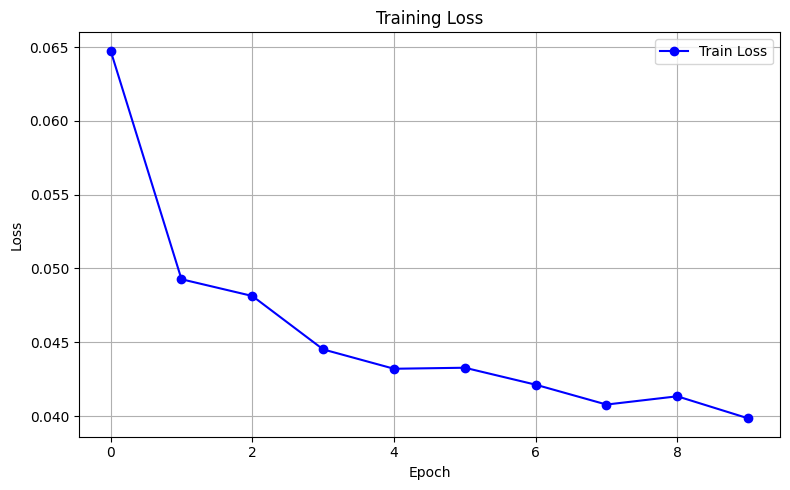

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', color='blue', marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

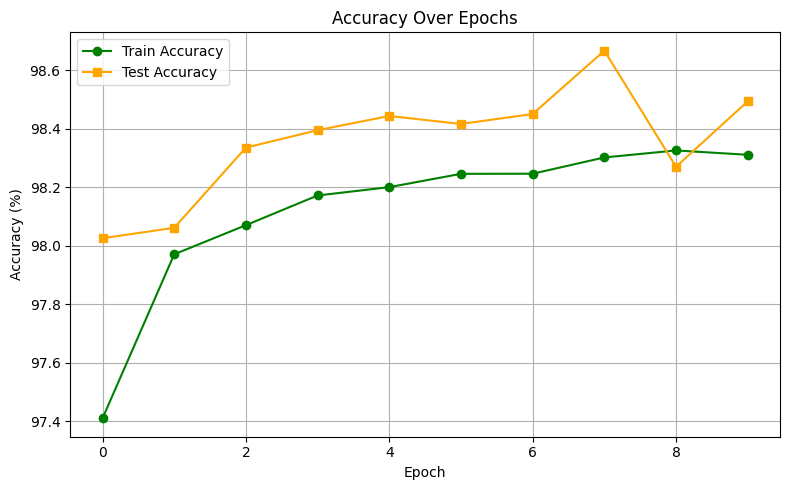

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Train Accuracy', color='green', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', color='orange', marker='s')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        test_total += y_batch.size(0)
        test_correct += (predicted == y_batch).sum().item()

print(f"\nTest Accuracy: {100 * test_correct / test_total:.2f}%")


Test Accuracy: 98.49%


In [28]:
torch.save(model.state_dict(), MODEL_PATH)
print(f"Модель сохранена в файл: {MODEL_PATH}")

Модель сохранена в файл: models/benign_or_attack_model.pth
